# Twitter Sentiment Analysis

Libraries Installation and Import

In [1]:
!pip install allennlp
!pip install --upgrade transformers
!pip install --upgrade torchvision
!pip install allennlp
!pip install torch
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 26.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/

In [2]:
import pandas as pd
import keras
import os
import sys
import re
from allennlp.modules.elmo import Elmo, batch_to_ids

import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D
import torch
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


Dataset Upload

In [3]:
# the dataset has to be .csv and has to have the same

from google.colab import files
uploaded = files.upload()


Saving goemotions_1.csv to goemotions_1.csv


In [4]:
dfData = pd.read_csv(io.BytesIO(uploaded['goemotions_1.csv']), encoding='latin-1')
dfData = pd.read_csv('/content/goemotions_1.csv', encoding='latin-1')


Processing and Balancing the dataset

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Assuming dfData is your original dataset
selected_columns = ['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
dfNewData = dfData[selected_columns]

# Identify the primary sentiment for each sample
dfNewData['target'] = dfNewData[selected_columns[1:]].idxmax(axis=1)

# Drop the additional sentiment columns (optional)
dfNewData = dfNewData.drop(selected_columns[1:], axis=1)

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
dfNewData['target_encoded'] = label_encoder.fit_transform(dfNewData['target'])

# Perform oversampling to balance the dataset without replication
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(dfNewData[['text']], dfNewData['target_encoded'])

# Create a new DataFrame with balanced data
dfBalanced = pd.DataFrame({'text': X_resampled['text'], 'target_encoded': y_resampled})

# Decode the numerical labels back to string labels
dfBalanced['target'] = label_encoder.inverse_transform(dfBalanced['target_encoded'])
dfBalanced = dfBalanced[['text', 'target']]

# Display the modified DataFrame
print(dfBalanced['target'].value_counts())
print(dfBalanced.shape[0])
print(dfBalanced.head())



sadness           18423
admiration        18423
fear              18423
relief            18423
desire            18423
pride             18423
grief             18423
anger             18423
surprise          18423
embarrassment     18423
approval          18423
joy               18423
remorse           18423
disgust           18423
caring            18423
excitement        18423
curiosity         18423
optimism          18423
confusion         18423
annoyance         18423
realization       18423
disappointment    18423
amusement         18423
disapproval       18423
gratitude         18423
love              18423
neutral           18423
nervousness       18423
Name: target, dtype: int64
515844
                                                text      target
0                                    That game hurt.     sadness
1   >sexuality shouldnât be a grouping category...  admiration
2     You do right, if you don't care then fuck 'em!     neutral
3                                 

<ipython-input-5-afe68e0cac19>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNewData['target'] = dfNewData[selected_columns[1:]].idxmax(axis=1)


Text preprocessing

In [6]:
#Eliminating all the special characters
def preprocess_tweet(tweet):
    # Remove mentions
    tweet = re.sub(r"@[A-Za-z0-9_]+", "", tweet)
    # Remove hashtags
    tweet = re.sub(r"#", "", tweet)
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    # Remove special characters and numbers
    tweet = re.sub(r"[^A-Za-z]+", " ", tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    return tweet

Text tokenization and pre-trained ELMo model loading & ELMO embeddings creation

In [7]:
# Tokenize text
def tokenize_text(df, max_tokens):
    df['tokens'] = df['text'].apply(lambda text: text_to_word_sequence(text, lower=False)[:max_tokens])

# Assuming dfData is your original dataset
dfBalanced['text'] = dfBalanced['text'].apply(preprocess_tweet)

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(dfBalanced, test_size=0.2, random_state=42)

# Tokenize text
max_tokens = 100
tokenize_text(train_data, max_tokens)
tokenize_text(test_data, max_tokens)




In [8]:
# Load the pre-trained ELMo model
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, 1, dropout=0)  # Adjust the dropout if needed
elmo.to(torch.device("cuda"))  # Move ELMo to GPU if available

def create_elmo_embeddings(elmo, documents, max_sentences=1000):
    num_sentences = min(max_sentences, len(documents)) if max_sentences > 0 else len(documents)
    print("\n\n:: Lookup of " + str(num_sentences) + " ELMo representations. This takes a while ::")
    embeddings = []
    labels = []

    for i in range(0, num_sentences, 50):  # Batch size of 50 to avoid GPU memory issues
        batch_documents = documents[i:i+50]
        batch_tokens = [document['tokens'] for _, document in batch_documents.iterrows()]  # Access tokens using iterrows()

        character_ids = batch_to_ids(batch_tokens).to(torch.device("cuda"))
        elmo_embedding = elmo(character_ids)
        avg_elmo_embedding = torch.mean(elmo_embedding['elmo_representations'][0], dim=1).detach().cpu().numpy()

        embeddings.extend(avg_elmo_embedding)
        labels.extend([document['target'] for _, document in batch_documents.iterrows()])

        # Some progress info
        percent = 100.0 * (i + 50) / num_sentences
        line = '[{0}{1}]'.format('=' * int(percent / 2), ' ' * (50 - int(percent / 2)))
        status = '\r{0:3.0f}%{1} {2:3d}/{3:3d} sentences'
        sys.stdout.write(status.format(percent, line, i + 50, num_sentences))

        if max_sentences > 0 and i + 50 >= max_sentences:
            break

    return embeddings, labels

# Lookup the ELMo embeddings for all documents in the dataset
train_x, train_y = create_elmo_embeddings(elmo, train_data, max_sentences=-1)
test_x, test_y = create_elmo_embeddings(elmo, test_data, max_sentences=-1)

# Reshape input data
train_x = np.array(train_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
test_y = np.array(test_y)






Output()

Output()



:: Lookup of 412675 ELMo representations. This takes a while ::
100%[==================================================] 412700/412675 sentences

:: Lookup of 103169 ELMo representations. This takes a while ::
100%[==================================================] 103200/103169 sentences

Neural Network Model Creation for classification

In [9]:

# Create the model
model = Sequential()
model.add(Conv1D(filters=250, kernel_size=3, padding='same', input_shape=(max_tokens, 1)))  # Adjust input shape
model.add(GlobalMaxPooling1D())
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(28, activation='softmax'))  # Change the number of neurons to 28 and use softmax activation




In [10]:

# Set the learning rate
chosen_lr = 0.001  # Replace with your chosen learning rate

# Update the learning rate in the optimizer
new_optimizer = Adam(learning_rate=chosen_lr)

# Compile the model with the new optimizer
model.compile(loss='binary_crossentropy', optimizer=new_optimizer, metrics=['accuracy'])

Model Training

In [11]:
# max_tokens is the correct maximum number of tokens
max_tokens = 100

# Ensure that each input sequence has the correct length
train_x_padded = np.array([np.pad(sequence, ((0, max_tokens - len(sequence)), (0, 0)), mode='constant')[:max_tokens] if len(sequence) < max_tokens else sequence[:max_tokens] for sequence in train_x])
test_x_padded = np.array([np.pad(sequence, ((0, max_tokens - len(sequence)), (0, 0)), mode='constant')[:max_tokens] if len(sequence) < max_tokens else sequence[:max_tokens] for sequence in test_x])



# Initialize lists to store metrics for each epoch
train_loss_values, train_accuracy_values = [], []
test_loss_values, test_accuracy_values = [], []
train_f1_values, train_precision_values, train_recall_values = [], [], []
test_f1_values, test_precision_values, test_recall_values = [], [], []
epochs = range(1, 51)  # Assuming you have 20 epochs

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# One-hot encode the labels
train_y_onehot = to_categorical(train_y_encoded, num_classes=28)
test_y_onehot = to_categorical(test_y_encoded, num_classes=28)

# Train the model and track metrics across epochs

for epoch in epochs:
    history = model.fit(train_x_padded, train_y_onehot, validation_data=(test_x_padded, test_y_onehot), epochs=1, batch_size=32, verbose=0)

    # Extract metrics from the training history
    train_loss_values.append(history.history['loss'][0])
    train_accuracy_values.append(history.history['accuracy'][0])

    # Evaluate the model on the test set using one-hot encoded labels
    test_loss, test_accuracy = model.evaluate(test_x_padded, test_y_onehot, verbose=0)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    # Compute F1-score, precision, and recall for training set
    train_predictions = model.predict(train_x_padded)
    train_predictions_argmax = np.argmax(train_predictions, axis=1)

    # Convert string labels to numerical format for F1 score calculation
    train_y_encoded = label_encoder.transform(train_y)
    train_f1 = f1_score(train_y_encoded, train_predictions_argmax, average='weighted')  # Adjust averaging method
    train_precision = precision_score(train_y_encoded, train_predictions_argmax, average='weighted')  # Adjust averaging method
    train_recall = recall_score(train_y_encoded, train_predictions_argmax, average='weighted')  # Adjust averaging method


    # Append values to lists
    train_f1_values.append(train_f1)
    train_precision_values.append(train_precision)
    train_recall_values.append(train_recall)

    # Compute F1-score, precision, and recall for test set
    test_predictions = model.predict(test_x_padded)
    test_predictions_argmax = np.argmax(test_predictions, axis=1)

    # Convert string labels to numerical format for F1 score calculation
    test_y_encoded = label_encoder.transform(test_y)
    test_f1 = f1_score(test_y_encoded, test_predictions_argmax, average='weighted')  # Adjust averaging method
    test_precision = precision_score(test_y_encoded, test_predictions_argmax, average='weighted')  # Adjust averaging method
    test_recall = recall_score(test_y_encoded, test_predictions_argmax, average='weighted')  # Adjust averaging method

    # Append values to lists
    test_f1_values.append(test_f1)
    test_precision_values.append(test_precision)
    test_recall_values.append(test_recall)

    # Print metrics for each epoch
    print(f"Epoch {epoch}/{len(epochs)} - "
          f"Train Loss: {train_loss_values[-1]:.4f}, "
          f"Train Accuracy: {train_accuracy_values[-1]:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}, "
          f"Train F1: {train_f1:.4f}, "
          f"Train Precision: {train_precision:.4f}, "
          f"Train Recall: {train_recall:.4f}, "
          f"Test F1: {test_f1:.4f}, "
          f"Test Precision: {test_precision:.4f}, "
          f"Test Recall: {test_recall:.4f}")


12897/12897 [==============================] - 22s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3225/3225 [==============================] - 6s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50 - Train Loss: 0.1544, Train Accuracy: 0.0422, Test Loss: 0.1537, Test Accuracy: 0.0468, Train F1: 0.0131, Train Precision: 0.0090, Train Recall: 0.0471, Test F1: 0.0130, Test Precision: 0.0090, Test Recall: 0.0468
12897/12897 [==============================] - 22s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3225/3225 [==============================] - 6s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/50 - Train Loss: 0.1533, Train Accuracy: 0.0529, Test Loss: 0.1529, Test Accuracy: 0.0567, Train F1: 0.0241, Train Precision: 0.0310, Train Recall: 0.0583, Test F1: 0.0236, Test Precision: 0.0396, Test Recall: 0.0567
12897/12897 [==============================] - 22s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3225/3225 [==============================] - 6s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/50 - Train Loss: 0.1522, Train Accuracy: 0.0661, Test Loss: 0.1515, Test Accuracy: 0.0761, Train F1: 0.0445, Train Precision: 0.0510, Train Recall: 0.0774, Test F1: 0.0438, Test Precision: 0.0504, Test Recall: 0.0761
12897/12897 [==============================] - 22s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3225/3225 [==============================] - 6s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/50 - Train Loss: 0.1500, Train Accuracy: 0.0903, Test Loss: 0.1478, Test Accuracy: 0.1088, Train F1: 0.0731, Train Precision: 0.0841, Train Recall: 0.1106, Test F1: 0.0720, Test Precision: 0.0800, Test Recall: 0.1088
3225/3225 [==============================] - 6s 2ms/step
Epoch 5/50 - Train Loss: 0.1459, Train Accuracy: 0.1245, Test Loss: 0.1446, Test Accuracy: 0.1345, Train F1: 0.0966, Train Precision: 0.1218, Train Recall: 0.1380, Test F1: 0.0934, Test Precision: 0.1118, Test Recall: 0.1345
3225/3225 [==============================] - 6s 2ms/step
Epoch 6/50 - Train Loss: 0.1406, Train Accuracy: 0.1639, Test Loss: 0.1382, Test Accuracy: 0.1807, Train F1: 0.1334, Train Precision: 0.1607, Train Recall: 0.1851, Test F1: 0.1298, Test Precision: 0.1575, Test Recall: 0.1807
3225/3225 [==============================] - 5s 2ms/step
Epoch 7/50 - Train Loss: 0.1352, Train Accuracy: 0.2016, Test Loss: 0.1330, Test Accuracy: 0.2177, Train F1: 0.1732, Train Precision: 0.1827, Train Recall

Metrics Calculation and plot

In [12]:
# Calculate and print the average metrics
avg_train_loss = sum(train_loss_values) / len(train_loss_values)
avg_train_accuracy = sum(train_accuracy_values) / len(train_accuracy_values)
avg_test_loss = sum(test_loss_values) / len(test_loss_values)
avg_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)

print("\nAverage Metrics Across Epochs:")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Average Test Accuracy: {avg_test_accuracy:.4f}")



Average Metrics Across Epochs:
Average Train Loss: 0.1097
Average Train Accuracy: 0.3748
Average Test Loss: 0.1123
Average Test Accuracy: 0.3620


In [13]:

# Print the final training loss and accuracy
train_loss, train_accuracy = model.evaluate(train_x_padded[..., np.newaxis], train_y_onehot, verbose=0)
test_loss, test_accuracy = model.evaluate(test_x_padded[..., np.newaxis], test_y_onehot, verbose=0)

print(f"\nFinal Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Use the trained model to make predictions
train_predictions = model.predict(train_x_padded[..., np.newaxis])
test_predictions = model.predict(test_x_padded[..., np.newaxis])

# Convert predictions to binary labels
train_predictions_binary = (train_predictions > 0.5).astype(int)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Print classification reports for train and test
print("\nTraining Classification Report:")
print(classification_report(train_y_onehot, train_predictions_binary))

print("\nTesting Classification Report:")
print(classification_report(test_y_onehot, test_predictions_binary))



Final Training Loss: 0.0919, Accuracy: 0.4952
3225/3225 [==============================] - 6s 2ms/step

Training Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.77      0.01      0.01     14733
           1       0.72      0.13      0.23     14646
           2       0.79      0.12      0.21     14812
           3       0.59      0.03      0.05     14723
           4       0.63      0.01      0.03     14785
           5       0.77      0.22      0.34     14760
           6       0.67      0.19      0.29     14763
           7       0.70      0.18      0.28     14727
           8       0.74      0.54      0.63     14676
           9       0.69      0.13      0.22     14730
          10       0.63      0.09      0.16     14676
          11       0.76      0.45      0.56     14734
          12       0.80      0.66      0.72     14821
          13       0.64      0.34      0.45     14773
          14       0.79      0.56      0.66     14660
          15       0.81      0.31      0.45     14791
          16       0.91      0.95      0.93     14825
          17       0.71    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


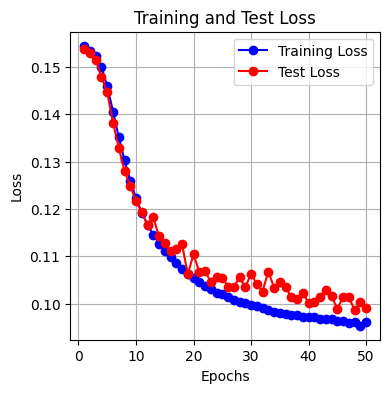

In [14]:
# Plotting the evolution of metrics


# Plotting loss values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss_values, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

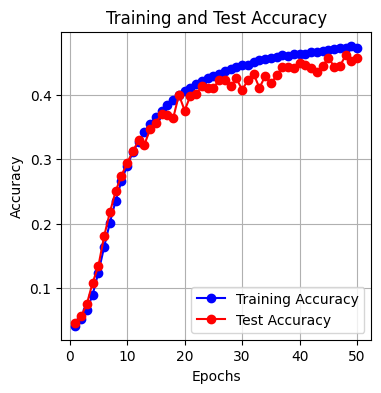

In [15]:

# Plotting accuracy values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_accuracy_values, 'bo-', label='Training Accuracy')
plt.plot(epochs, test_accuracy_values, 'ro-', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

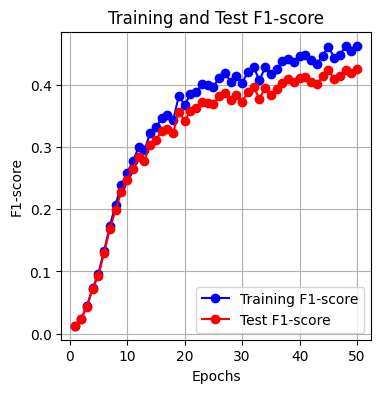

In [16]:
# Plotting F1-score values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_f1_values, 'bo-', label='Training F1-score')
plt.plot(epochs, test_f1_values, 'ro-', label='Test F1-score')
plt.title('Training and Test F1-score')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

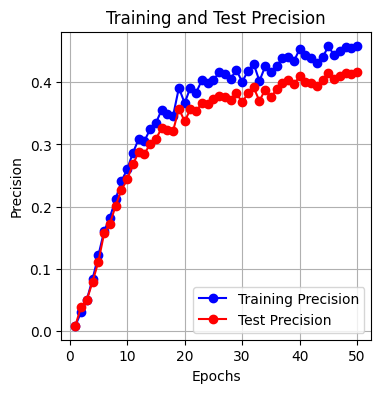

In [17]:
# Plotting Precision values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_precision_values, 'bo-', label='Training Precision')
plt.plot(epochs, test_precision_values, 'ro-', label='Test Precision')
plt.title('Training and Test Precision')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


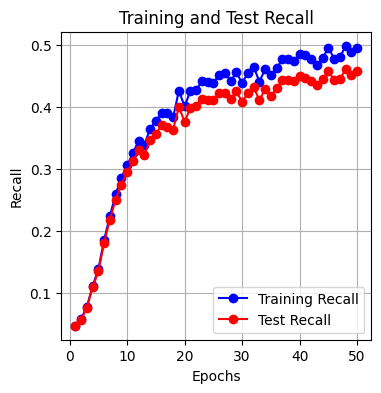

In [18]:

# Plotting Recall values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_recall_values, 'bo-', label='Training Recall')
plt.plot(epochs, test_recall_values, 'ro-', label='Test Recall')
plt.title('Training and Test Recall')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

Length of train_y_labels: 412675
Length of train_predictions_binary: 412675


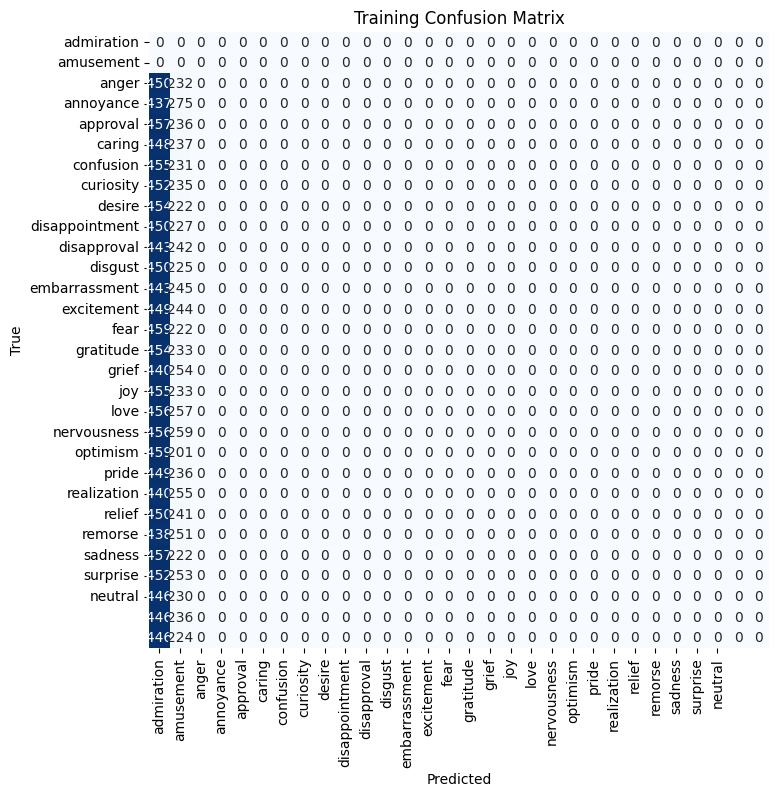

In [19]:
#Train confusion matrix
# Ensure that train_y has the correct shape and is 2D
if len(train_y.shape) > 1:
    train_y_labels = np.argmax(train_y, axis=1).flatten()
else:
    train_y_labels = train_y.flatten()

# Ensure that train_predictions_binary has the correct shape
train_predictions_binary = (train_predictions > 0.5).astype(int).flatten()

# Convert train_predictions_binary to the same type as train_y_labels
train_predictions_binary = train_predictions_binary.astype(train_y_labels.dtype)

# Trim train_predictions_binary to match the length of train_y_labels
train_predictions_binary = train_predictions_binary[:len(train_y_labels)]

# Print lengths for debugging
print("Length of train_y_labels:", len(train_y_labels))
print("Length of train_predictions_binary:", len(train_predictions_binary))

# Assuming you have a list of sentiment names in the order of numerical codes
sentiment_names = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


# Now you can compute and plot the confusion matrix with sentiment names
conf_matrix_train = confusion_matrix(train_y_labels, train_predictions_binary)

# Plotting confusion matrix with sentiment names
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=sentiment_names, yticklabels=sentiment_names)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Length of test_y_labels: 103169
Length of test_predictions_binary: 103169


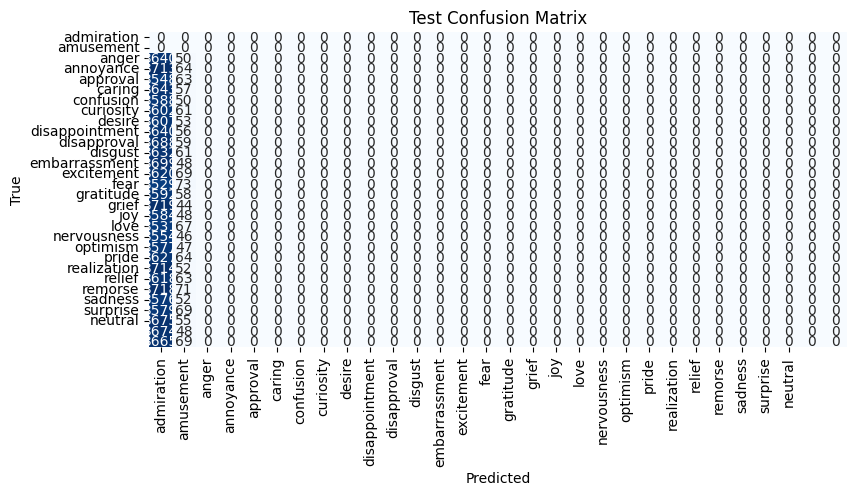

In [20]:
#Test confusion matrix
# Ensure that test_y has the correct shape and is 2D
if len(test_y.shape) > 1:
    test_y_labels = np.argmax(test_y, axis=1).flatten()
else:
    test_y_labels = test_y.flatten()

# Ensure that test_predictions_binary has the correct shape
test_predictions_binary = (test_predictions > 0.5).astype(int).flatten()

# Convert test_predictions_binary to the same type as test_y_labels
test_predictions_binary = test_predictions_binary.astype(test_y_labels.dtype)

# Trim test_predictions_binary to match the length of test_y_labels
test_predictions_binary = test_predictions_binary[:len(test_y_labels)]

# Print lengths for debugging
print("Length of test_y_labels:", len(test_y_labels))
print("Length of test_predictions_binary:", len(test_predictions_binary))

# Assuming you have a list of sentiment names, replace it with your actual list
sentiment_names = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

# Now you can compute and plot the confusion matrix for the test set
conf_matrix_test = confusion_matrix(test_y_labels, test_predictions_binary)

# Plotting confusion matrix for the test set
plt.figure(figsize=(9, 9))  # Adjust the figure size as needed
plt.subplot(2, 1, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=sentiment_names, yticklabels=sentiment_names)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

